# Deep analysis: VLM→L→V attractor basins (500 images × 10 iters)

This notebook is designed to help you extract **publishable** plots/tables from an existing run without re-running generation.

**Core “kicker” this notebook builds:** define final-iteration K-Means centroids as *attractors* and measure **basin absorption** over time (how quickly images enter and stay in their final basin).

It also produces:
- step-size dynamics (largest jump is often iter0→iter1: projection onto diffusion manifold)
- drift-to-original dynamics in CLIP space
- within-vs-between basin separation over time
- cluster/basin semantics and retention differences


In [21]:
from pathlib import Path
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image

from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

plt.style.use("seaborn-v0_8-whitegrid")

# repo root = parent of the notebooks folder
REPO_ROOT = Path.cwd().resolve().parent
RUN_DIR = REPO_ROOT / "experiments/10_iter_12.17/20251217_183826_iter10_img500"
CSV_PATH = RUN_DIR / "20251217_183826_iter10_img500_iteration_results.csv"
KMEANS_JSON = RUN_DIR / "kmeans_analysis.json"
IMAGES_DIR = RUN_DIR / "images"

FIG_DIR = RUN_DIR / "plots" / "paper_figures"
FIG_DIR.mkdir(parents=True, exist_ok=True)

print("RUN_DIR exists:", RUN_DIR.exists())
print("CSV exists:", CSV_PATH.exists())

RUN_DIR exists: True
CSV exists: True


## Load artifacts

In [22]:
df = pd.read_csv(CSV_PATH)
df = df.sort_values(["image_id", "iteration"]).reset_index(drop=True)
df[["iteration", "image_id"]] = df[["iteration", "image_id"]].astype(int)

with open(KMEANS_JSON, "r", encoding="utf-8") as f:
    kmeans_obj = json.load(f)

print("rows:", len(df))
print("images:", df["image_id"].nunique())
print("iterations:", df["iteration"].nunique(), "(min/max)", df["iteration"].min(), df["iteration"].max())
print("kmeans k_values:", kmeans_obj.get("k_values"))
print("kmeans pca_components:", kmeans_obj.get("pca_components"))

rows: 5000
images: 500
iterations: 10 (min/max) 0 9
kmeans k_values: [2, 3, 4, 5, 6, 7, 8]
kmeans pca_components: 256


## Load CLIP embeddings (from checkpoints)

The pipeline saved per-iteration CLIP embeddings for each image (normalized). We'll merge checkpoints into one array per iteration.

In [23]:
def load_all_checkpoints(run_dir: Path):
    ckpts = sorted(run_dir.glob("checkpoint_imgs*.npz"))
    if not ckpts:
        raise FileNotFoundError(f"No checkpoints in {run_dir}")

    embeddings_by_iter = {}
    image_ids = []
    for ckpt in ckpts:
        data = np.load(ckpt, allow_pickle=True)
        embs = data["embeddings_by_iter"].item()
        for it, arr in embs.items():
            embeddings_by_iter.setdefault(int(it), []).append(np.array(arr))
        image_ids.extend([int(x) for x in data["image_ids"]])

    for it in list(embeddings_by_iter.keys()):
        embeddings_by_iter[it] = np.vstack(embeddings_by_iter[it])

    return embeddings_by_iter, np.array(image_ids, dtype=np.int32)


emb_by_iter, image_ids = load_all_checkpoints(RUN_DIR)
iters = sorted(emb_by_iter.keys())
print("iters:", iters)
print("emb shape @iter0:", emb_by_iter[iters[0]].shape)
print("image_ids unique:", len(np.unique(image_ids)))

# sanity: embeddings are normalized
norms = np.linalg.norm(emb_by_iter[iters[0]], axis=1)
print("norm mean/std:", norms.mean(), norms.std())

iters: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
emb shape @iter0: (500, 768)
image_ids unique: 500
norm mean/std: 0.9999768 0.00023758967


## Helper: simple bootstrap CI (for paper-style error bands)

In [24]:
def bootstrap_mean_ci(values: np.ndarray, n_boot: int = 300, ci: float = 95.0, seed: int = 0):
    """Bootstrap mean CI by resampling indices (fast, vectorized)."""
    values = np.asarray(values)
    values = values[np.isfinite(values)]
    n = len(values)
    if n == 0:
        return np.nan, np.nan, np.nan
    rng = np.random.default_rng(seed)
    idx = rng.integers(0, n, size=(n_boot, n))
    means = values[idx].mean(axis=1)
    lo = np.percentile(means, (100 - ci) / 2)
    hi = np.percentile(means, 100 - (100 - ci) / 2)
    return float(values.mean()), float(lo), float(hi)


bootstrap_mean_ci(np.random.randn(500))

(-0.07867210236028462, -0.15891364683362194, 0.00664350401440027)

## Figure 1: step size dynamics (CLIP)

This is a clean story: **iter0→iter1 is typically the biggest jump** (projection onto diffusion manifold), and step sizes shrink afterwards.

PosixPath('/Users/deancasey/Documents/Columbia/vlm-iterative-loss/experiments/10_iter_12.17/20251217_183826_iter10_img500/plots/paper_figures/fig1_step_size_ci.png')

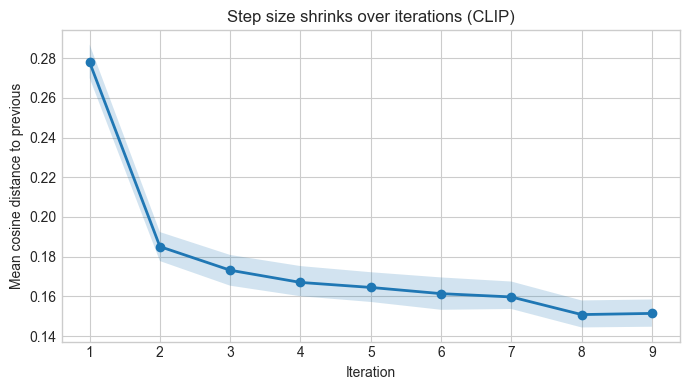

In [25]:
def cosine_distance(a: np.ndarray, b: np.ndarray) -> np.ndarray:
    # embeddings are normalized, so cosine distance is 1 - dot
    return 1.0 - np.sum(a * b, axis=1)


step_means, step_lows, step_highs = [], [], []
step_iters = []
for it in iters[1:]:
    d = cosine_distance(emb_by_iter[it], emb_by_iter[it - 1])
    m, lo, hi = bootstrap_mean_ci(d, n_boot=300, seed=42 + it)
    step_iters.append(it)
    step_means.append(m)
    step_lows.append(lo)
    step_highs.append(hi)

plt.figure(figsize=(7, 4))
plt.plot(step_iters, step_means, marker="o", linewidth=2)
plt.fill_between(step_iters, step_lows, step_highs, alpha=0.2)
plt.xlabel("Iteration")
plt.ylabel("Mean cosine distance to previous")
plt.title("Step size shrinks over iterations (CLIP)")
plt.tight_layout()
out = FIG_DIR / "fig1_step_size_ci.png"
plt.savefig(out, dpi=300)
out

## Figure 2: drift to original image in CLIP space

This quantifies *how much the image changes* relative to the original, in a standard semantic space.

PosixPath('/Users/deancasey/Documents/Columbia/vlm-iterative-loss/experiments/10_iter_12.17/20251217_183826_iter10_img500/plots/paper_figures/fig2_drift_to_original_ci.png')

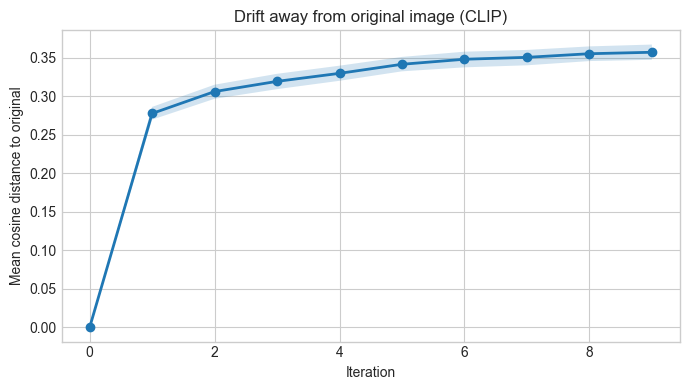

In [26]:
drift_means, drift_lows, drift_highs = [], [], []
for it in iters:
    d = cosine_distance(emb_by_iter[it], emb_by_iter[0])
    m, lo, hi = bootstrap_mean_ci(d, n_boot=300, seed=123 + it)
    drift_means.append(m)
    drift_lows.append(lo)
    drift_highs.append(hi)

plt.figure(figsize=(7, 4))
plt.plot(iters, drift_means, marker="o", linewidth=2)
plt.fill_between(iters, drift_lows, drift_highs, alpha=0.2)
plt.xlabel("Iteration")
plt.ylabel("Mean cosine distance to original")
plt.title("Drift away from original image (CLIP)")
plt.tight_layout()
out = FIG_DIR / "fig2_drift_to_original_ci.png"
plt.savefig(out, dpi=300)
out

## Figure 3: basin absorption curve (the “kicker”)

Define **final iteration K-Means centroids** as attractors. Project all iterations into the **same PCA space** (fit on final iteration) and track:
- fraction already in their final basin
- switching rate
- “commitment time”: first iteration when an image enters its final basin and never leaves

This reads like dynamical systems / attractor basin evidence.

(PosixPath('/Users/deancasey/Documents/Columbia/vlm-iterative-loss/experiments/10_iter_12.17/20251217_183826_iter10_img500/plots/paper_figures/fig3_basin_absorption.png'),
 (0.632, 0.732, 0.906))

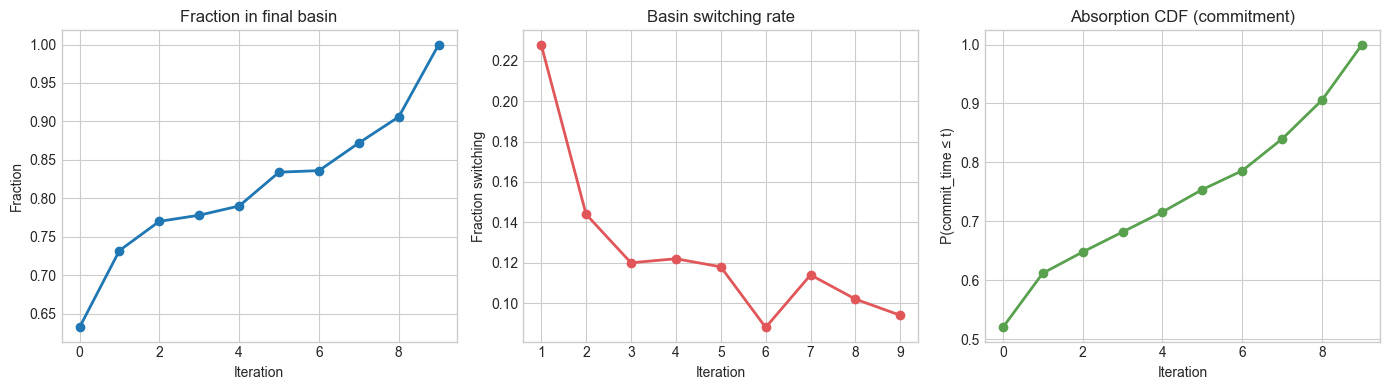

In [27]:
FINAL_IT = max(iters)
K_ATTRACTORS = 8
PCA_COMPS = 256

# Fit basin model on final iteration
pca = PCA(n_components=PCA_COMPS, random_state=42)
Xf = pca.fit_transform(emb_by_iter[FINAL_IT])
km = KMeans(n_clusters=K_ATTRACTORS, n_init=20, max_iter=500, random_state=42)
labels_final = km.fit_predict(Xf)
centroids = km.cluster_centers_

# Assign all iterations to final centroids
labels_by_iter = {}
for it in iters:
    Xt = pca.transform(emb_by_iter[it])
    d = np.linalg.norm(Xt[:, None, :] - centroids[None, :, :], axis=-1)
    labels_by_iter[it] = d.argmin(axis=1)

match_final = [(labels_by_iter[it] == labels_final).mean() for it in iters]
switch_rate = [np.nan] + [(labels_by_iter[it] != labels_by_iter[it - 1]).mean() for it in iters[1:]]

# commitment time (absorbing basin time)
n = len(labels_final)
commit_time = np.full(n, -1, dtype=int)
for i in range(n):
    lf = labels_final[i]
    for t in iters:
        if all(labels_by_iter[tt][i] == lf for tt in iters if tt >= t):
            commit_time[i] = t
            break

commit_cdf = [(commit_time <= t).mean() for t in iters]

fig, axes = plt.subplots(1, 3, figsize=(14, 4))

axes[0].plot(iters, match_final, marker="o", linewidth=2)
axes[0].set_title("Fraction in final basin")
axes[0].set_xlabel("Iteration")
axes[0].set_ylabel("Fraction")

axes[1].plot(iters, switch_rate, marker="o", linewidth=2, color="#E15759")
axes[1].set_title("Basin switching rate")
axes[1].set_xlabel("Iteration")
axes[1].set_ylabel("Fraction switching")

axes[2].plot(iters, commit_cdf, marker="o", linewidth=2, color="#59A14F")
axes[2].set_title("Absorption CDF (commitment)")
axes[2].set_xlabel("Iteration")
axes[2].set_ylabel("P(commit_time ≤ t)")

plt.tight_layout()
out = FIG_DIR / "fig3_basin_absorption.png"
plt.savefig(out, dpi=300)
out, (match_final[0], match_final[1], match_final[-2])

## Figure 4: within vs between basin distances

Using **final basin labels** (fixed), compute within-basin and between-basin mean cosine distances over time.

A clean claim: within-basin distances shrink faster than between-basin distances, so basin separation becomes more pronounced.

(PosixPath('/Users/deancasey/Documents/Columbia/vlm-iterative-loss/experiments/10_iter_12.17/20251217_183826_iter10_img500/plots/paper_figures/fig4_within_between.png'),
 (0.4538629651069641,
  0.34456098079681396,
  0.506956160068512,
  0.4372345805168152))

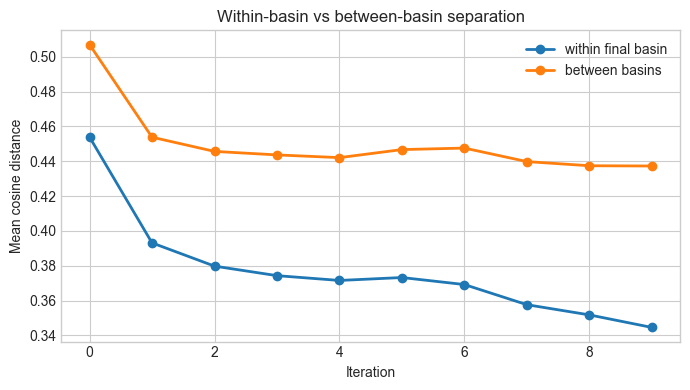

In [28]:
def within_between_means(E: np.ndarray, labels: np.ndarray):
    # cosine dist = 1 - dot; use upper triangle
    sim = E @ E.T
    dist = 1.0 - sim
    iu = np.triu_indices_from(dist, k=1)
    dist_u = dist[iu]
    same = (labels[iu[0]] == labels[iu[1]])
    within = dist_u[same]
    between = dist_u[~same]
    return float(within.mean()), float(between.mean())


within_means, between_means = [], []
for it in iters:
    w, b = within_between_means(emb_by_iter[it], labels_final)
    within_means.append(w)
    between_means.append(b)

plt.figure(figsize=(7, 4))
plt.plot(iters, within_means, marker="o", linewidth=2, label="within final basin")
plt.plot(iters, between_means, marker="o", linewidth=2, label="between basins")
plt.xlabel("Iteration")
plt.ylabel("Mean cosine distance")
plt.title("Within-basin vs between-basin separation")
plt.legend()
plt.tight_layout()
out = FIG_DIR / "fig4_within_between.png"
plt.savefig(out, dpi=300)
out, (within_means[0], within_means[-1], between_means[0], between_means[-1])

## Figure 5: attractor prototypes (representative images)

For each final basin, show the 2 nearest images to the centroid (in final PCA space).

This gives you a **visually compelling “attractor gallery”** for a paper slide/figure.

PosixPath('/Users/deancasey/Documents/Columbia/vlm-iterative-loss/experiments/10_iter_12.17/20251217_183826_iter10_img500/plots/paper_figures/fig5_attractor_gallery_iter9.png')

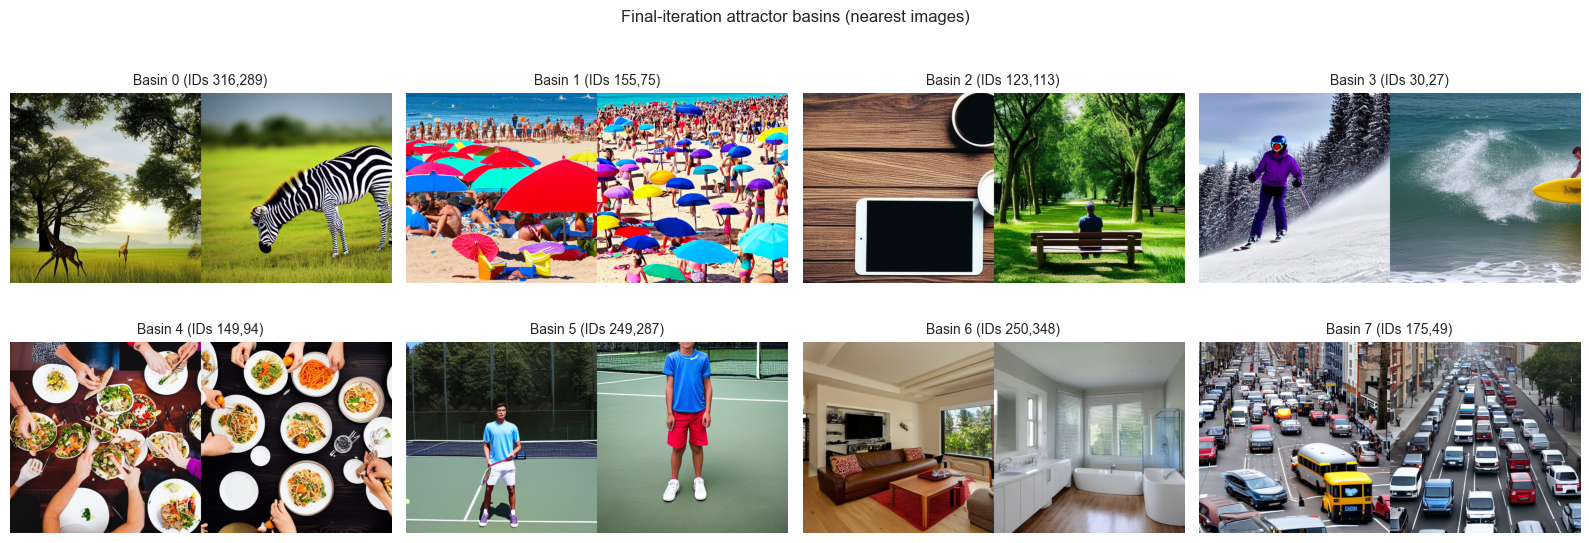

In [29]:
def img_path(image_id: int, iteration: int) -> Path:
    # original saved at iter0 with suffix _original
    if iteration == 0:
        return IMAGES_DIR / f"{RUN_DIR.name}_img{image_id:03d}_iter0_original.png"
    return IMAGES_DIR / f"{RUN_DIR.name}_img{image_id:03d}_iter{iteration}_generated.png"


def hconcat(img_a: Image.Image, img_b: Image.Image) -> Image.Image:
    # resize to same height
    h = min(img_a.size[1], img_b.size[1])
    img_a = img_a.resize((int(img_a.size[0] * h / img_a.size[1]), h))
    img_b = img_b.resize((int(img_b.size[0] * h / img_b.size[1]), h))
    out = Image.new("RGB", (img_a.size[0] + img_b.size[0], h))
    out.paste(img_a, (0, 0))
    out.paste(img_b, (img_a.size[0], 0))
    return out


# nearest-to-centroid in final PCA space
d_to_centroid = np.linalg.norm(Xf[:, None, :] - centroids[None, :, :], axis=-1)
nearest_indices = {c: np.argsort(d_to_centroid[:, c])[:2] for c in range(K_ATTRACTORS)}

rep_imgs = []
rep_titles = []
for c in range(K_ATTRACTORS):
    idx_a, idx_b = nearest_indices[c]
    id_a = int(image_ids[idx_a])
    id_b = int(image_ids[idx_b])
    a = Image.open(img_path(id_a, FINAL_IT)).convert("RGB")
    b = Image.open(img_path(id_b, FINAL_IT)).convert("RGB")
    rep_imgs.append(hconcat(a, b))
    rep_titles.append(f"Basin {c} (IDs {id_a},{id_b})")

fig, axes = plt.subplots(2, 4, figsize=(16, 6))
axes = axes.flatten()
for ax, im, title in zip(axes, rep_imgs, rep_titles):
    ax.imshow(im)
    ax.set_title(title, fontsize=10)
    ax.axis("off")
plt.suptitle("Final-iteration attractor basins (nearest images)")
plt.tight_layout()
out = FIG_DIR / "fig5_attractor_gallery_iter9.png"
plt.savefig(out, dpi=250)
out

## Figure 6: basin-specific information retention

Join final basin labels to your CSV metrics and show that some basins lose caption-information faster than others.

This is an easy story to tell: attractors differ not only semantically, but also in how much they preserve original caption semantics.

In [30]:
# build mapping image_id -> final basin
basin_map = pd.DataFrame({"image_id": image_ids.astype(int), "basin": labels_final.astype(int)})

# final-iteration row per image
final_df = df[df["iteration"] == FINAL_IT].copy()
final_df = final_df.merge(basin_map, on="image_id", how="inner")

# per-image slope of similarity_to_original from iter1..final
pivot = df.pivot(index="image_id", columns="iteration", values="similarity_to_original")
xs = np.arange(1, FINAL_IT + 1, dtype=float)
slopes = {}
for image_id, row in pivot.iterrows():
    ys = row.loc[1:FINAL_IT].values.astype(float)
    if np.any(~np.isfinite(ys)):
        continue
    slope = np.cov(xs, ys, bias=True)[0, 1] / np.var(xs)
    slopes[int(image_id)] = float(slope)

slopes_df = pd.DataFrame({"image_id": list(slopes.keys()), "sim_slope": list(slopes.values())})
final_df = final_df.merge(slopes_df, on="image_id", how="left")

basin_stats = final_df.groupby("basin").agg(
    n=("image_id", "count"),
    sim_final_mean=("similarity_to_original", "mean"),
    sim_final_std=("similarity_to_original", "std"),
    sim_slope_mean=("sim_slope", "mean"),
    bert_mean=("bert_f1", "mean"),
    jacc_mean=("jaccard", "mean"),
).reset_index().sort_values("n", ascending=False)

basin_stats

,basin,n,sim_final_mean,sim_final_std,sim_slope_mean,bert_mean,jacc_mean
2,2,99,0.629112,0.141240,-0.021465,0.900638,0.264974
4,4,80,0.689235,0.124653,-0.017944,0.900780,0.278156
7,7,74,0.612208,0.142576,-0.024592,0.893770,0.246257
6,6,65,0.704389,0.124978,-0.017665,0.905249,0.298644
3,3,58,0.737316,0.115819,-0.011662,0.910923,0.304144
0,0,57,0.716117,0.155645,-0.015959,0.908619,0.292671
1,1,44,0.615571,0.153824,-0.025335,0.895292,0.243155
5,5,23,0.774509,0.124564,-0.010718,0.904954,0.300830


PosixPath('/Users/deancasey/Documents/Columbia/vlm-iterative-loss/experiments/10_iter_12.17/20251217_183826_iter10_img500/plots/paper_figures/fig6_basin_retention.png')

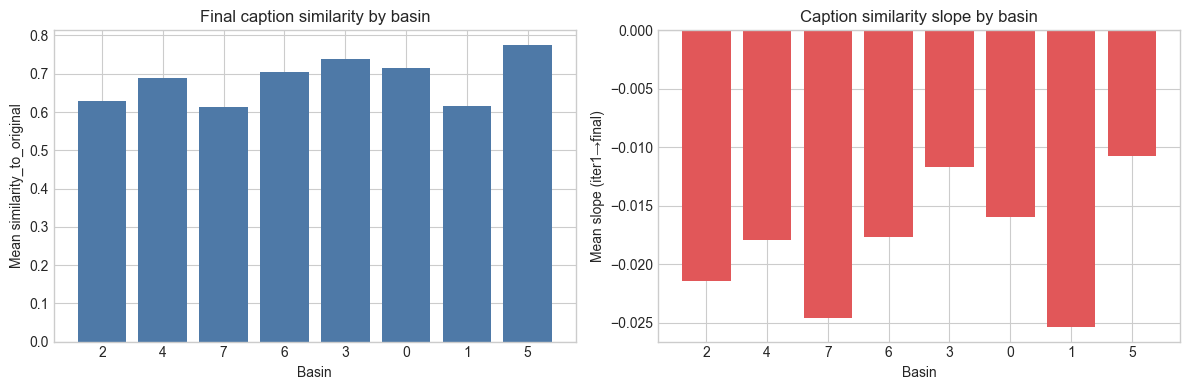

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

axes[0].bar(basin_stats["basin"].astype(str), basin_stats["sim_final_mean"], color="#4E79A7")
axes[0].set_title("Final caption similarity by basin")
axes[0].set_xlabel("Basin")
axes[0].set_ylabel("Mean similarity_to_original")

axes[1].bar(basin_stats["basin"].astype(str), basin_stats["sim_slope_mean"], color="#E15759")
axes[1].set_title("Caption similarity slope by basin")
axes[1].set_xlabel("Basin")
axes[1].set_ylabel("Mean slope (iter1→final)")

plt.tight_layout()
out = FIG_DIR / "fig6_basin_retention.png"
plt.savefig(out, dpi=300)
out

## Optional: caption keywords per basin

This helps you *name* the attractors in a paper figure (e.g., “traffic jam”, “beach crowd”, “indoor room”).

It’s a quick, dependency-free approach: tokenize captions, remove stopwords, and print the top words per basin.

In [32]:
import re
from collections import Counter

STOPWORDS = {
    "a","an","the","and","or","of","to","in","on","with","for","at","by","from","as","is","are","was","were",
    "this","that","it","its","their","there","these","those","image","depicts","features","shows","scene","view",
    "one","two","three","several","many","near","visible","can","seen","also","appears","appearing"
}

def top_words(texts, n=12):
    tokens = []
    for t in texts:
        if not isinstance(t, str):
            continue
        ws = re.findall(r"[a-zA-Z']+", t.lower())
        ws = [w for w in ws if w not in STOPWORDS and len(w) >= 3]
        tokens.extend(ws)
    return Counter(tokens).most_common(n)

caption_words = (
    final_df.groupby("basin")["caption"]
    .apply(lambda s: top_words(s.tolist(), n=12))
    .to_dict()
)

for basin, words in sorted(caption_words.items()):
    print(f"Basin {basin}: {[w for (w, _) in words]}")

Basin 0: ['field', 'green', 'lush', 'others', 'some', 'creating', 'standing', 'sheep', 'trees', 'closer', 'grass', 'positioned']
Basin 1: ['people', 'some', 'others', 'umbrellas', 'crowd', 'beach', 'closer', 'atmosphere', 'lively', 'large', 'various', 'standing']
Basin 2: ['table', 'side', 'man', 'sitting', 'other', 'placed', 'some', 'standing', 'enjoying', 'field', 'others', 'people']
Basin 3: ['wearing', 'people', 'some', 'man', 'others', 'slope', 'enjoying', 'snow', 'group', 'standing', 'captures', 'skis']
Basin 4: ['table', 'placed', 'some', 'meal', 'dining', 'food', 'variety', 'others', 'side', 'people', 'other', 'enjoying']
Basin 5: ['tennis', 'court', 'standing', 'racket', 'wearing', 'holding', 'picture', 'baseball', 'posing', 'group', 'women', 'possibly']
Basin 6: ['room', 'side', 'placed', 'bathroom', 'space', 'sink', 'large', 'adding', 'couch', 'right', 'potted', 'left']
Basin 7: ['street', 'people', 'cars', 'city', 'some', 'busy', 'filled', 'others', 'bustling', 'traffic', '

## Suggested paper packaging (minimal, high-impact)

**Figure 1 (Dynamics)**: `fig1_step_size_ci.png` + `fig2_drift_to_original_ci.png`.
- Caption idea: *“Iterative V→L→V acts as a contraction: step sizes shrink and images drift away from the original primarily in the first iteration (projection onto the diffusion manifold).”*

**Figure 2 (Kicker / Attractors)**: `fig3_basin_absorption.png`.
- Caption idea: *“Final-iteration centroids define attractor basins; images enter and remain in their terminal basin quickly (absorption curve).”*

**Figure 3 (What are the attractors?)**: `fig5_attractor_gallery_iter9.png`.
- Caption idea: *“Attractor basins correspond to a small set of semantically coherent archetypes (examples shown).”*

**Figure 4 (Optional, strengthens story)**: `fig6_basin_retention.png`.
- Caption idea: *“Different basins preserve source-caption semantics to different degrees.”*

If you only have time for **one “big kicker” slide**, show Figure 2 + Figure 3 together.

## Paper-ready summary numbers (copy/paste)

Use these as “headline” results in your abstract/slide:
- contraction in CLIP space (pairwise distance, drift)
- absorption curve milestones (e.g. % in final basin at iter1, iter8)
- convergence rate from `scripts/analyze_attractors.py` (VLM vision embedding fixed points)


In [33]:
pairwise0 = float(kmeans_obj["results_by_iteration"]["0"]["pairwise_mean"])
pairwise9 = float(kmeans_obj["results_by_iteration"][str(FINAL_IT)]["pairwise_mean"])
sil0 = float(kmeans_obj["results_by_iteration"]["0"]["best_silhouette"])
sil9 = float(kmeans_obj["results_by_iteration"][str(FINAL_IT)]["best_silhouette"])

print("CLIP pairwise mean distance:", f"{pairwise0:.4f} → {pairwise9:.4f}", f"({(pairwise9-pairwise0)/pairwise0*100:+.1f}%)")
print("Silhouette (chosen k):", f"{sil0:.4f} → {sil9:.4f}", f"({(sil9-sil0)/sil0*100:+.1f}%)")
print("Basin match-final fraction:")
print("  iter0:", f"{match_final[0]*100:.1f}%")
print("  iter1:", f"{match_final[1]*100:.1f}%")
print("  iter8:", f"{match_final[-2]*100:.1f}%")

print("Commitment CDF:")
for t in [0, 1, 3, 5, 8]:
    print(f"  P(commit_time ≤ {t}): {commit_cdf[t]*100:.1f}%")


CLIP pairwise mean distance: 0.4996 → 0.4244 (-15.0%)
Silhouette (chosen k): 0.1123 → 0.1708 (+52.1%)
Basin match-final fraction:
  iter0: 63.2%
  iter1: 73.2%
  iter8: 90.6%
Commitment CDF:
  P(commit_time ≤ 0): 52.0%
  P(commit_time ≤ 1): 61.2%
  P(commit_time ≤ 3): 68.2%
  P(commit_time ≤ 5): 75.4%
  P(commit_time ≤ 8): 90.6%


/Users/deancasey/Documents/Columbia/vlm-iterative-loss/info_loss/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


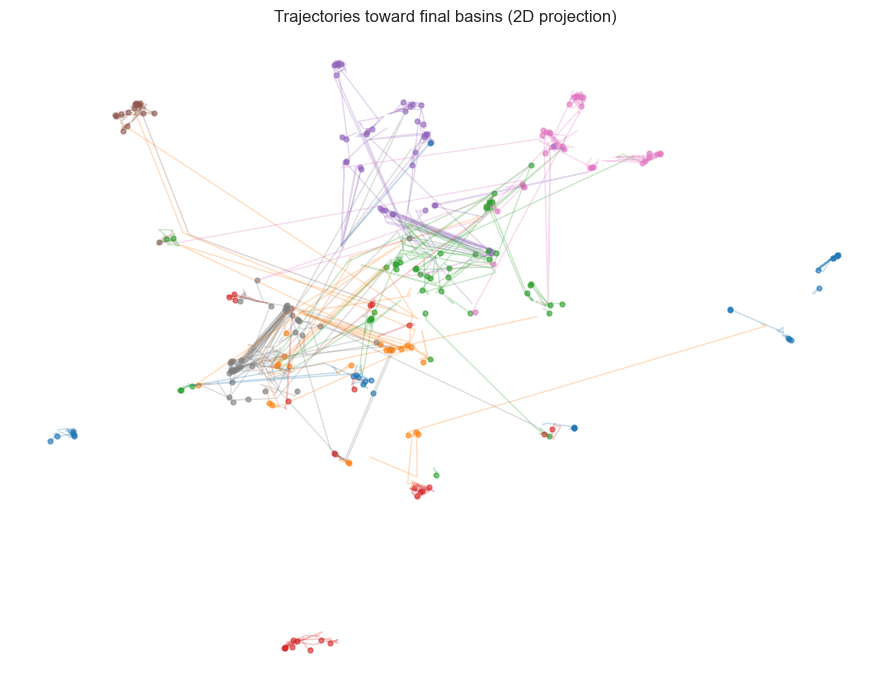

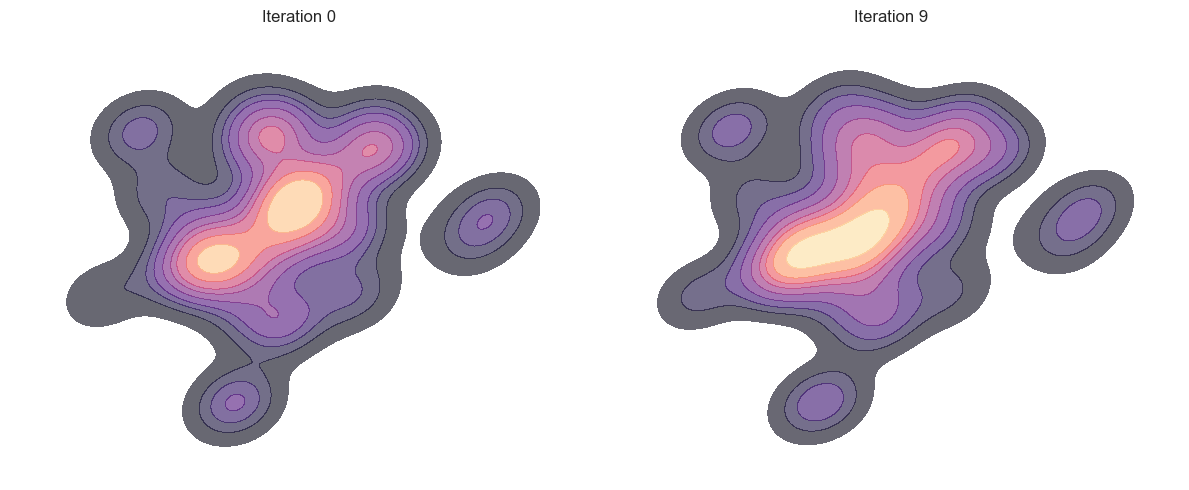

In [37]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from umap import UMAP  # pip install umap-learn
from sklearn.decomposition import PCA

# ---- Fit projector on concatenated embeddings (or just final iter) ----
all_emb = np.vstack([emb_by_iter[it] for it in iters])  # or emb_by_iter[FINAL_IT]
pca50 = PCA(n_components=50, random_state=42).fit(all_emb)
umap2 = UMAP(n_components=2, random_state=42, metric="cosine").fit(pca50.transform(all_emb))

# ---- Project each iteration ----
proj_by_iter = {}
for it in iters:
    proj_by_iter[it] = umap2.transform(pca50.transform(emb_by_iter[it]))

# ---- Basin labels (final) ----
labels_final = labels_by_iter[FINAL_IT]  # from the basin assignment step

# ---- Sample a subset for trajectories ----
rng = np.random.default_rng(0)
idx = rng.choice(len(labels_final), size=min(250, len(labels_final)), replace=False)

plt.figure(figsize=(9, 7))
for i in idx:
    xs = [proj_by_iter[it][i, 0] for it in iters]
    ys = [proj_by_iter[it][i, 1] for it in iters]
    c = plt.cm.tab10(labels_final[i] % 10)
    plt.plot(xs, ys, '-', color=c, alpha=0.25, linewidth=1)
    plt.scatter(xs[-1], ys[-1], color=c, s=12, alpha=0.6)

plt.title("Trajectories toward final basins (2D projection)")
plt.axis('off')
plt.tight_layout()
plt.savefig(FIG_DIR / "traj_umap.png", dpi=300)
plt.show()

# ---- KDE contours per iteration (global density) ----
fig, axes = plt.subplots(1, 2, figsize=(12,5))
for ax, it in zip(axes, [0, FINAL_IT]):
    xy = proj_by_iter[it]
    sns.kdeplot(x=xy[:,0], y=xy[:,1], fill=True, levels=10, cmap="magma", alpha=0.6, ax=ax)
    ax.set_title(f"Iteration {it}")
    ax.axis('off')
plt.tight_layout()
plt.savefig(FIG_DIR / "kde_iter0_vs_final.png", dpi=300)
plt.show()